<h1>Text Classification Using BERT</h1>

In [37]:
#import paskages
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#Load data
df=pd.read_csv("/content/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
df_spam= df[df['Category']=='spam']
df_ham= df[df['Category']=='ham']

In [7]:
df_spam.shape

(747, 2)

In [8]:
df_ham.shape

(4825, 2)

In [9]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [10]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [11]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [12]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
148,ham,Ummma.will call after check in.our life will b...,0
3679,spam,Promotion Number: 8714714 - UR awarded a City ...,1
2556,spam,FreeMSG You have been awarded a FREE mini DIGI...,1
2359,ham,I'll talk to the others and probably just come...,0
623,ham,MAKE SURE ALEX KNOWS HIS BIRTHDAY IS OVER IN F...,0


In [13]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [14]:
X_train.head(1)

1248    Horrible gal. Me in sch doing some stuff. How ...
Name: Message, dtype: object

In [15]:
y_train.head(1)

1248    0
Name: spam, dtype: int64

import BERT model and get embeding vectors for few sample statements

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
def get_sentence_embeding(sentences):
  preprocessed_text= bert_preprocess(sentences)

  return bert_encoder(preprocessed_text)['pooled_output']

In [18]:
get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [19]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [20]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.760692  , -0.14219385,  0.49604586, ...,  0.42165312,
        -0.532214  ,  0.8031219 ],
       [-0.86023223, -0.2124296 ,  0.49156848, ...,  0.39797997,
        -0.60506296,  0.8447167 ],
       [-0.7128862 , -0.15463911,  0.384017  , ...,  0.3527875 ,
        -0.5099134 ,  0.734741  ],
       [-0.82533467, -0.35550597, -0.5906975 , ..., -0.01613778,
        -0.61417586,  0.8723029 ],
       [-0.75041336, -0.2681262 , -0.26689708, ...,  0.02839353,
        -0.5938098 ,  0.7974988 ],
       [-0.78544426, -0.2994976 ,  0.41027158, ...,  0.52225286,
        -0.49573594,  0.8150757 ]], dtype=float32)>

In [21]:
cosine_similarity([e[0]],[e[1]])


array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits



In [22]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703827]], dtype=float32)

In [23]:
cosine_similarity([e[3]],[e[4]])


array([[0.9872036]], dtype=float32)

Build Model

In [24]:
text_input = tf.keras.layers.Input(shape=() ,dtype=tf.string ,name='text')
preprocessed_text  = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text )

In [25]:
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [26]:
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [27]:
len(X_train)


1120

In [28]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [29]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 642s 18s/step - loss: 0.6134 - accuracy: 0.6759 - precision: 0.6644 - recall: 0.7107
Epoch 2/10
35/35 [==============================] - 611s 17s/step - loss: 0.5015 - accuracy: 0.8161 - precision: 0.7921 - recall: 0.8571
Epoch 3/10
35/35 [==============================] - 605s 17s/step - loss: 0.4426 - accuracy: 0.8500 - precision: 0.8391 - recall: 0.8661
Epoch 4/10
35/35 [==============================] - 612s 17s/step - loss: 0.3969 - accuracy: 0.8607 - precision: 0.8367 - recall: 0.8964
Epoch 5/10
35/35 [==============================] - 612s 17s/step - loss: 0.3673 - accuracy: 0.8759 - precision: 0.8550 - recall: 0.9054
Epoch 6/10
35/35 [==============================] - 631s 18s/step - loss: 0.3446 - accuracy: 0.8955 - precision: 0.8852 - recall: 0.9089
Epoch 7/10
35/35 [==============================] - 626s 18s/step - loss: 0.3284 - accuracy: 0.8893 - precision: 0.8707 - recall: 0.9143
Epoch 8/10
35/35 [=======================

In [30]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 217s 17s/step - loss: 0.2600 - accuracy: 0.9332 - precision: 0.9309 - recall: 0.9358


[0.26004812121391296,
 0.9331550598144531,
 0.9308510422706604,
 0.9358288645744324]

In [31]:
y_predicted = model.predict(X_test)


12/12 [==============================] - 218s 18s/step


In [34]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
    

In [36]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[174,  13],
       [ 12, 175]])

<Axes: >

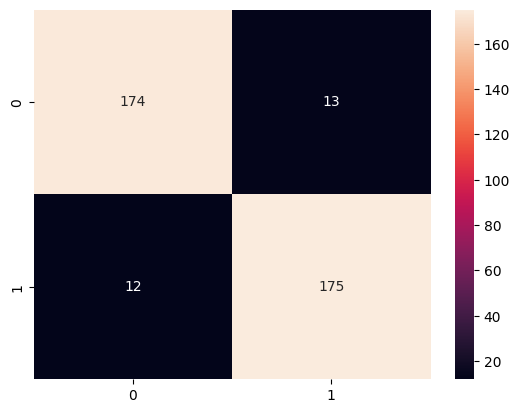

In [38]:
sn.heatmap(cm ,annot=True ,fmt='d')

In [39]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       187
           1       0.93      0.94      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [40]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 8s 8s/step


array([[0.739544  ],
       [0.7930071 ],
       [0.73997015],
       [0.19627234],
       [0.08935358]], dtype=float32)

####################

#####################

In [42]:
model.save("/content/saved_model/1/")

In [43]:
model.save("/content/saved_model/2/")

In [44]:
model.save("/content/saved_model/3/")